In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import datetime as datetime
import datetime as dt

In [10]:
folder = '/Users/nam-yeong/Downloads/data'
files = os.listdir('/Users/nam-yeong/Downloads/data')

files[0]

path = os.path.join(folder,files[0])

df = pd.read_csv(path,encoding='utf-8')


In [16]:
df.head()

,Attributed Touch Type,Attributed Touch Time,Install Time,Event Time,Event Name,Event Value,Event Revenue,Event Revenue Currency,Event Revenue KRW,Cost Model,...,Retargeting Conversion Type,Is Primary Attribution,Attribution Lookback,Reengagement Window,Match Type,User Agent,HTTP Referrer,Original URL,Device Model,Store Product Page
0,click,2023-10-02 18:33:28,2023-10-02 18:38:00,2023-11-30 23:59:53,TC_benefit_list,"{""benefit_id"":""1""}",NaN,USD,NaN,NaN,...,NaN,False,7d,NaN,probabilistic,BalloSodeuk/23112401 CFNetwork/1335.0.3.4 Darw...,NaN,http://webjoin.balso.io/66rp/x2v4l1j5?remote-i...,iPhone7,NaN
1,click,NaN,2023-11-30 23:14:37,2023-11-30 23:59:52,TC_benefit_list,"{""benefit_id"":""9""}",NaN,USD,NaN,NaN,...,NaN,True,7d,NaN,srn,BalloSodeuk/23112401 CFNetwork/1485 Darwin/23.1.0,NaN,NaN,iPhoneSE3rdGen,NaN
2,click,2023-11-06 00:07:41,2023-11-06 00:08:46,2023-11-30 23:59:52,TC_benefit_list,"{""benefit_id"":""7""}",NaN,USD,NaN,NaN,...,NaN,True,7d,NaN,probabilistic,BalloSodeuk/23112401 CFNetwork/1485 Darwin/23.1.0,NaN,https://app.appsflyer.com/id1630747840?pid=adi...,iPhoneXSMax,NaN
3,click,NaN,2023-11-30 23:14:37,2023-11-30 23:59:48,TC_benefit_list,"{""benefit_id"":""1""}",NaN,USD,NaN,NaN,...,NaN,True,7d,NaN,srn,BalloSodeuk/23112401 CFNetwork/1485 Darwin/23.1.0,NaN,NaN,iPhoneSE3rdGen,NaN
4,click,2023-11-29 12:42:15,2023-11-29 12:42:36,2023-11-30 23:59:47,TC_benefit_list,"{""benefit_id"":""5""}",NaN,USD,NaN,NaN,...,NaN,True,7d,NaN,probabilistic,BalloSodeuk/23112401 CFNetwork/1399 Darwin/22.1.0,NaN,https://balso.onelink.me/g9qe/8ajtl4cr,iPhone13Pro,NaN


In [27]:
# df.groupby('AppsFlyer ID')[['Event Time']].count()

# df['Event Time'] = pd.to_datetime(df['Event Time'])
# df['datetime'] = df['Event Time'].dt.strftime('%Y-%m-%d')

df.datetime.unique()

array(['2023-11-30', '2023-11-29', '2023-11-28', '2023-11-27',
       '2023-11-26', '2023-11-25', '2023-11-24'], dtype=object)

In [114]:
# df_ = df.groupby(['AppsFlyer ID','datetime'])[['Event Time']].nunique().reset_index()
# df_ = df_.groupby('AppsFlyer ID')['datetime'].agg(['min','max']).reset_index()
# df_['days'] = pd.to_datetime(df_['max']) - pd.to_datetime(df_['min'])
# df_['days'] = df_['days'].dt.days

# df_['event'] = df_.apply(lambda x : 1 if x['min'] < '2023-11-28' and x['days'] < 3  else 0, axis = 1)

df_['max'] = pd.to_datetime(df_['max'])
df_['min'] = pd.to_datetime(df_['min'])
reference_date = pd.to_datetime('2023-11-24')

df_['start'] = (df_['min'] - reference_date).dt.days
df_['end'] = (df_['max'] - reference_date).dt.days




In [116]:
df__ = df_[['AppsFlyer ID','start','end','event']]
df__

,AppsFlyer ID,start,end,event
0,1673791398783-1685089,1,6,0
1,1674732172799-1430634,0,4,0
2,1675320765735-2680952,2,2,1
3,1675397430529-9725641,0,6,0
4,1675606351832-6220540,0,6,0
...,...,...,...,...
19035,1701355655968-1081483,6,6,0
19036,1701355793604-7427578,6,6,0
19037,1701355797018-7258778,6,6,0
19038,1701355877112-7197836,6,6,0


In [119]:
df__.set_index('AppsFlyer ID',inplace=True)

In [121]:
df__

,start,end,event
AppsFlyer ID,,,
1673791398783-1685089,1,6,0
1674732172799-1430634,0,4,0
1675320765735-2680952,2,2,1
1675397430529-9725641,0,6,0
1675606351832-6220540,0,6,0
...,...,...,...
1701355655968-1081483,6,6,0
1701355793604-7427578,6,6,0
1701355797018-7258778,6,6,0


ValueError: '1675320765735-2680952' is not a valid format string (unrecognized character '6')

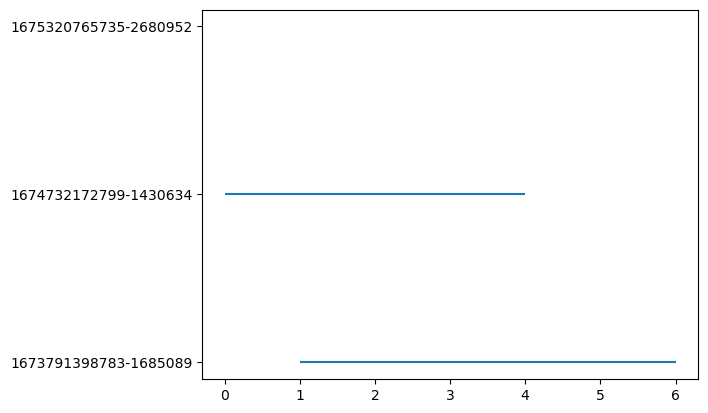

In [122]:
def plot_lifelines(df__):
    for y,row in df__.iterrows():
        start = row['start']
        end = row['end']
        status = row['event']

        if status == 0:
            plt.hlines(y,start,end,color='C0')
        else :
            plt.hlines(y,start,end,color='C1')
            plt.plot(end,y,marker='o',color='C1')
    plt.xlabel('Time (weeks)')
    plt.ylabel('Dog Index')
    plt.gca().invert_yaxis()

plot_lifelines(df__)

In [ ]:



import pandas as pd

# 예시 DataFrame 생성
data = {'date_column': pd.date_range('2023-11-23', '2023-11-25')}
df = pd.DataFrame(data)

# 기준일로부터의 날짜 차이 계산하여 새로운 열 생성
reference_date = pd.to_datetime('2023-11-23')
df['day_difference'] = (df['date_column'] - reference_date).dt.days

# 결과 확인
print(df)


In [106]:
df_.event.value_counts()

event
0    11157
1     7883
Name: count, dtype: int64

In [108]:
df_

,AppsFlyer ID,min,max,days,event
0,1673791398783-1685089,2023-11-25,2023-11-30,5,0
1,1674732172799-1430634,2023-11-24,2023-11-28,4,0
2,1675320765735-2680952,2023-11-26,2023-11-26,0,1
3,1675397430529-9725641,2023-11-24,2023-11-30,6,0
4,1675606351832-6220540,2023-11-24,2023-11-30,6,0
...,...,...,...,...,...
19035,1701355655968-1081483,2023-11-30,2023-11-30,0,0
19036,1701355793604-7427578,2023-11-30,2023-11-30,0,0
19037,1701355797018-7258778,2023-11-30,2023-11-30,0,0
19038,1701355877112-7197836,2023-11-30,2023-11-30,0,0


In [104]:
df_[(df_['min']=='2023-11-30') & (df_[max]=='2023-11-30')]

,AppsFlyer ID,min,max,days,event
10,1676385364543-1900324,2023-11-30,2023-11-30,0,0
25,1677479006456-2400381,2023-11-30,2023-11-30,0,0
63,1679127592075-4090271,2023-11-30,2023-11-30,0,0
74,1679285698016-8712161,2023-11-30,2023-11-30,0,0
109,1679720729472-8529244,2023-11-30,2023-11-30,0,0
...,...,...,...,...,...
19035,1701355655968-1081483,2023-11-30,2023-11-30,0,0
19036,1701355793604-7427578,2023-11-30,2023-11-30,0,0
19037,1701355797018-7258778,2023-11-30,2023-11-30,0,0
19038,1701355877112-7197836,2023-11-30,2023-11-30,0,0


In [103]:
df_[df_['event']==0]

,AppsFlyer ID,min,max,days,event
0,1673791398783-1685089,2023-11-25,2023-11-30,5,0
1,1674732172799-1430634,2023-11-24,2023-11-28,4,0
3,1675397430529-9725641,2023-11-24,2023-11-30,6,0
4,1675606351832-6220540,2023-11-24,2023-11-30,6,0
5,1675999413392-3620774,2023-11-24,2023-11-30,6,0
...,...,...,...,...,...
19035,1701355655968-1081483,2023-11-30,2023-11-30,0,0
19036,1701355793604-7427578,2023-11-30,2023-11-30,0,0
19037,1701355797018-7258778,2023-11-30,2023-11-30,0,0
19038,1701355877112-7197836,2023-11-30,2023-11-30,0,0


In [113]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19040 entries, 0 to 19039
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   AppsFlyer ID  19040 non-null  object
 1   min           19040 non-null  object
 2   max           19040 non-null  object
 3   days          19040 non-null  int64 
 4   event         19040 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 743.9+ KB


In [109]:

from lifelines import KaplanMeierFitter


kmf = KaplanMeierFitter()
kmf.fit(df_['max'], df_['event'])

plot = kmf.plot_survival_function()




/Users/nam-yeong/miniforge3/envs/tf28/lib/python3.9/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


TypeError: Wrong dtype 'object'.

In [39]:
 data.time.value_counts()

time
2    2994
1       6
Name: count, dtype: int64